##### N0003.CAM 可视化

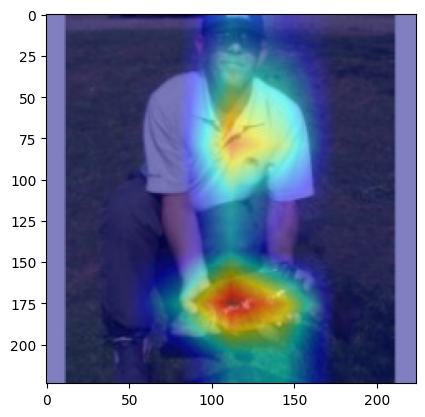

In [4]:
"""
预训练 ImageNet-ResNet CAM 可视化
CAM 可视化的输入层需要有空间分辨率 (H,W,C) 经 GAP 得到
不调库的实现: https://b23.tv/SQVKqp2
"""
import torch
from torchvision import models
from torchvision import transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

model = models.resnet50(pretrained=True)
model.cuda().eval()

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
])
image = Image.open('/datasets/ImageNet-1K/train/n01440764/n01440764_10026.JPEG').convert('RGB')
image = data_transforms(image) # 网络输入需要归一化图像，但可视化时需要裁剪的原图
input_tensor = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image).unsqueeze(0).cuda()

target_layers = [model.layer4[1].bn2] # [model.layer4[-1]] [model.layer4[0].conv1]
cam = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)  # targets=None 表示使用模型预测的最高概率类别
grayscale_cam = grayscale_cam[0]

image = np.array(image).transpose(1, 2, 0)
visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.show()

##### N0002.tSNE 可视化

In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels):
    """
    Args:
        features: (N, M), N 个归一化的样本，每个 M 维
        labels: (N, ) 聚类标签
    """
    import pandas as pd
    import seaborn

    df = pd.DataFrame({'x': features[:, 0], 'y': features[:, 1], 'label': labels})
    seaborn.scatterplot(
        data=df, x="x", y="y", hue=df.label, 
        palette=seaborn.color_palette("hls", len(np.unique(labels))),
    ).set(title="T-SNE")

data shape: (1083, 64), data_tsne shape: (1083, 2)


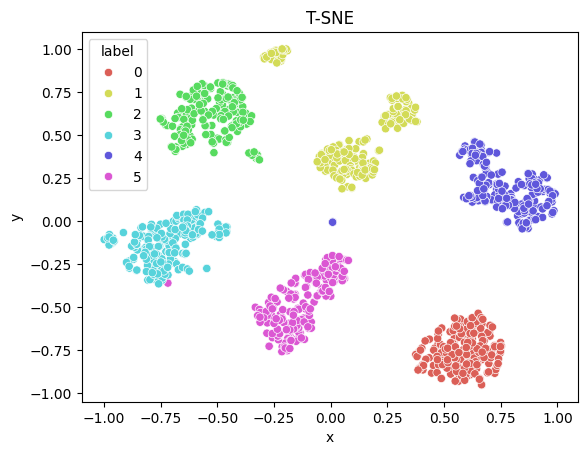

In [2]:
"""
MNIST 高维原始数据降维可视化
TSNE(): Kimi sklearn.manifold.TSNE
    n_components: 降维后的特征空间维度
    random_state: 设置为一个整数随机种子确保结果可重复
"""
import numpy as np
from sklearn import datasets

# dataset
digits = datasets.load_digits(n_class=6) # MNIST test set 的子集，10 类总样本数 1797, 特征维度 8x8=64
data, label, (n_samples, n_features) = digits.data, digits.target, digits.data.shape

tsne = TSNE(n_components=2, init='pca', random_state=0)
data_tsne = tsne.fit_transform(data)
data_tsne = (data_tsne - data_tsne.min()) / (data_tsne.max() - data_tsne.min()) * 2 - 1
print(f"data shape: {data.shape}, data_tsne shape: {data_tsne.shape}")
plot_tsne(data_tsne, label)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


data shape: (120, 2048), data_tsne shape: (120, 2)


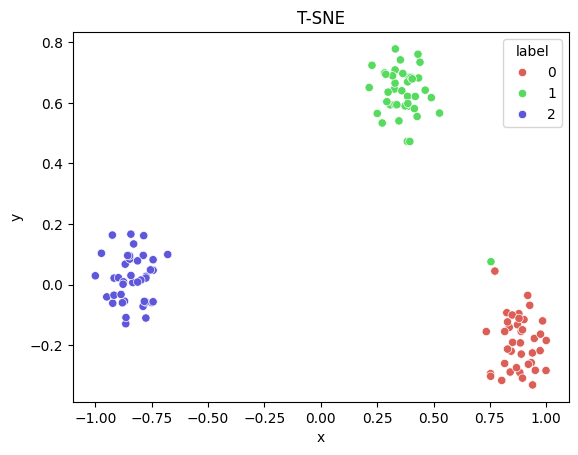

In [2]:
"""
预训练 ImageNet-ResNet 特征降维可视化
树叶型 TSNE: 就是修改网络，原本的网络 fc 输出 num_cls 维，修改为 fc1 输出 2 维，再 fc2 输出 num_cls 维，则 fc1 的输出可以直接可视化 https://b23.tv/SQVKqp2 17:00
"""
import torch
from torchvision import models
import numpy as np

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

model = models.resnet50(pretrained=True)
model.cuda().eval()
model.fc = Identity() # 恒等连接替换全连接层以获取进入全连接层之前的 CNN 特征

# feat_list, label_list = [], []
# for i in range(60):
#     input = torch.randn(1, 3, 224, 224)
#     pred = model(input.cuda())
#     feat_list.append(pred.detach().cpu().numpy())
#     if i < 20: label_list.append(0)
#     elif i < 40: label_list.append(1)
#     else: label_list.append(2)

# data, label = np.concatenate(feat_list), np.array(label_list)
# tsne = TSNE(n_components=2, init='pca', random_state=0)
# data_tsne = tsne.fit_transform(data)
# data_tsne = (data_tsne - data_tsne.min()) / (data_tsne.max() - data_tsne.min()) * 2 - 1
# print(f"data shape: {data.shape}, data_tsne shape: {data_tsne.shape}")
# plot_tsne(data_tsne, label)

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from glob import glob
from pathlib import Path
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root, label_names, transform=None):
        self.image_paths = []
        self.labels = []
        for i, label_name in enumerate(label_names):
            self.image_paths += glob(f"{root/label_name}/*")[:40]
            self.labels += [i]*40
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        
        return image, label
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
label_names = ['n02097209', 'n02110341', 'n02169497']
dataset = CustomDataset(root=Path("/datasets/ImageNet-1K/train/"), label_names=label_names, transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)
feat_list, label_list = [], []
for images, labels in dataloader:
    input = images
    pred = model(input.cuda())
    feat_list.append(pred.detach().cpu().numpy())
    label_list.extend(labels.numpy().tolist())

data, label = np.concatenate(feat_list), np.array(label_list)
tsne = TSNE(n_components=2, init='pca', random_state=0)
data_tsne = tsne.fit_transform(data)
data_tsne = (data_tsne - data_tsne.min()) / (data_tsne.max() - data_tsne.min()) * 2 - 1
print(f"data shape: {data.shape}, data_tsne shape: {data_tsne.shape}")
plot_tsne(data_tsne, label)

##### N0001.关于损失函数

In [3]:
import torch
lossL1 = torch.nn.L1Loss()
lossMSE = torch.nn.MSELoss()
lossBCEWLogits = torch.nn.BCEWithLogitsLoss()
x = torch.ones((3, 10, 10)) * 2
y = torch.zeros((3, 10, 10))
print("lossL1", lossL1(x, y)) # sum(abs(A[i]-B[i])) / size(A)
print("lossMSE", lossMSE(x, y)) # sum((A[i]-B[i])**2) / size(A)
print("lossL1", lossBCEWLogits(x, y)) # 二元交叉熵损失并使用 Sigmoid 激活

lossL1 tensor(2.)
lossMSE tensor(4.)
lossL1 tensor(2.1269)
